In [1]:
!pip install duckdb rdkit

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyarrow as pa
import pyarrow.parquet as pq

from tqdm import tqdm
from pathlib import Path
import itertools
from collections import defaultdict

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
from collections import Counter


train_pq = pq.ParquetFile("/content/drive/MyDrive/DS5500/train.parquet")

SAVEDIR = Path("/content/drive/MyDrive/DS5500/")
SAVEDIR.mkdir(exist_ok=True)

DRAFT_MODE = False


train_path = '/content/drive/MyDrive/DS5500/train.parquet'
test_path = '/content/drive/MyDrive/DS5500/test.parquet'

con = duckdb.connect()

In [4]:
sample = con.query(f"""(SELECT * FROM parquet_scan('{train_path}') WHERE binds = 1 LIMIT 10)""").df()

sample

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,466,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Cc1cc2cc(CN)ccc2[nH]1,C#CCOc1ccc(CNc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(N[C...,HSA,1
1,467,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Cc1cc2cc(CN)ccc2[nH]1,C#CCOc1ccc(CNc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(N[C...,sEH,1
2,683,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Cl.NCC12CC3CC(CC(C3)C1)C2,C#CCOc1ccc(CNc2nc(NCC34CC5CC(CC(C5)C3)C4)nc(N[...,sEH,1
3,1321,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Nc1n[nH]c2ncccc12,C#CCOc1ccc(CNc2nc(Nc3n[nH]c4ncccc34)nc(N[C@@H]...,HSA,1
4,2141,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1cccc(CN)c1.Cl,Cc1cc2cc(CN)ccc2[nH]1,C#CCOc1cccc(CNc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(N[...,sEH,1
5,3739,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#Cc1ccc(N)cc1,CCOC(=O)c1nonc1N,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(Nc2ccc(C#C)cc2)nc...,HSA,1
6,4292,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#Cc1ccc(N)cc1,Cc1cc2cc(CN)ccc2[nH]1,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCc2ccc3[nH]c(C)c...,sEH,1
7,6425,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#Cc1cccc(N)c1,Cc1cc2cc(CN)ccc2[nH]1,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCc2ccc3[nH]c(C)c...,sEH,1
8,8743,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C=C(C)COCCN.Cl,CN1CCN(C(=O)CN)CC1,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCOCC(=C)C)nc(NC...,HSA,1
9,9031,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C=C(C)COCCN.Cl,COc1cncc(N)c1,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCOCC(=C)C)nc(Nc...,HSA,1


In [6]:
str(list(sample.columns))


"['id', 'buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles', 'molecule_smiles', 'protein_name', 'binds']"

In [7]:
binds_stats = con.query(f"""(SELECT binds, COUNT(*) as binds_count FROM parquet_scan('{train_path}') GROUP BY binds ORDER BY COUNT(*) DESC)""").df()
binds_stats

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,binds,binds_count
0,0,293656924
1,1,1589906


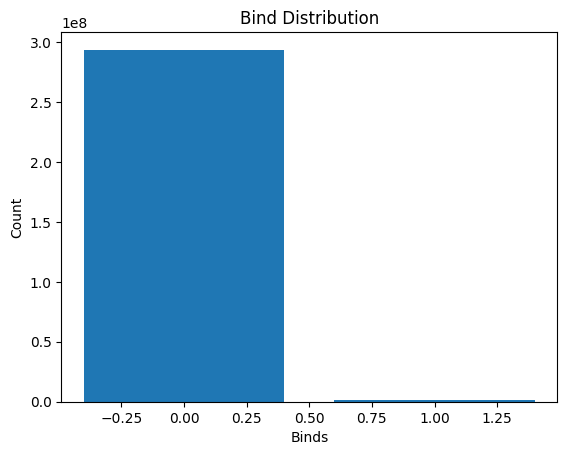

In [8]:
plt.bar(binds_stats['binds'], binds_stats['binds_count'])
plt.xlabel('Binds')
plt.ylabel('Count')
plt.title('Bind Distribution')
plt.show()

In [9]:
protein_stats = con.query(f"""(SELECT protein_name, COUNT(*) as protein_count FROM parquet_scan('{train_path}') GROUP BY protein_name ORDER BY COUNT(*) DESC)""").df()
protein_stats

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,protein_name,protein_count
0,HSA,98415610
1,sEH,98415610
2,BRD4,98415610


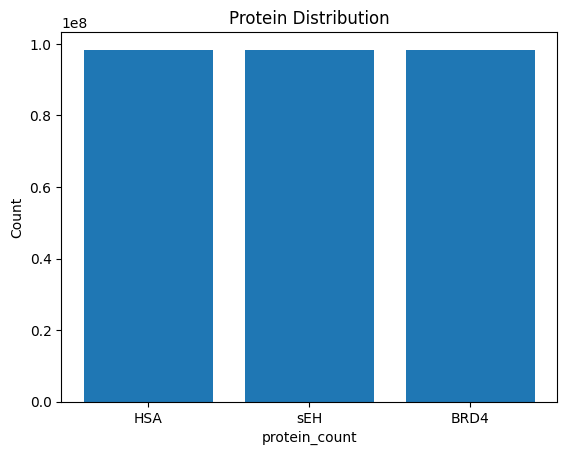

In [10]:
plt.bar(protein_stats['protein_name'], protein_stats['protein_count'])
plt.xlabel('protein_count')
plt.ylabel('Count')
plt.title('Protein Distribution')
plt.show()

## Analysis: 3 types of protein with an equal distribution of protein

In [11]:
protein_binds_stats = con.query(f"""(SELECT protein_name, binds, COUNT(*) as protein_bind_count FROM parquet_scan('{train_path}') GROUP BY protein_name, binds ORDER BY COUNT(*) DESC)""").df()
protein_binds_stats

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,protein_name,binds,protein_bind_count
0,HSA,0,98007200
1,BRD4,0,97958646
2,sEH,0,97691078
3,sEH,1,724532
4,BRD4,1,456964
5,HSA,1,408410


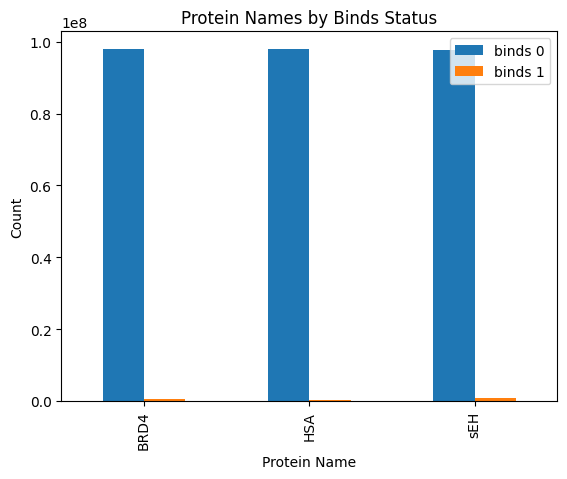

In [10]:
grouped = protein_binds_stats.groupby(['protein_name', 'binds']).sum().unstack('binds')
grouped.plot(kind='bar', stacked=False)
plt.xlabel('Protein Name')
plt.ylabel('Count')
plt.title('Protein Names by Binds Status')
plt.legend(labels=['binds 0', 'binds 1'])
plt.show()

In [13]:
meged_df = con.query(f"""(SELECT COUNT(*) as total_rows FROM parquet_scan('{train_path}'))
                        UNION ALL
                        (SELECT COUNT(*) as total_rows FROM parquet_scan('{test_path}'))""").df()

In [14]:
meged_df

,total_rows
0,295246830
1,1674896


In [65]:
protein_names = ["BRD4", "HSA", "sEH"]

smiles_col_names = [
    "buildingblock1_smiles",
    "buildingblock2_smiles",
    "buildingblock3_smiles",
    "molecule_smiles"
]

# SCHEMA of SMILE molecules that have binding affinity with all three protein

schema_single_target = pa.schema([
    (col_name, pa.string())
    for col_name in smiles_col_names
])

# SCHEMA of SMILE molecules that have binding affinity with one or more proteins
schema_mixed_target = pa.schema([
    (col_name, pa.string())
    for col_name in smiles_col_names
] + [(prot_name, pa.int8()) for prot_name in protein_names])

# SCHEMA of SMILE molecules that have binding affinity with no proteins
schema_unprocessed = pa.schema([
    (col_name, pa.string())
    for col_name in smiles_col_names
] + [
    ('protein_name', pa.string()),
    ('binds', pa.int8())
])


# Mapping the values to different keys used for partitioning
suffix_map = [
    ("all0", schema_single_target),
    ("all1", schema_single_target),
    ("all_mixed", schema_mixed_target),
    ('unprocessed', schema_unprocessed)
]

###Wrapper func to add the molecules to different groups based on partition

In [66]:
class PqDataSaverWrapper:
    def __init__(self, savedir="/content/drive/MyDrive/DS5500/", keys_info=suffix_map, prefix="train"):

        self.file_handlers = None

        if isinstance(savedir, str):
            savedir = Path(savedir)

        self.savedir = savedir
        self.keys_info = keys_info
        self.prefix = prefix

    def add_data(self, df_dict):

      if self.file_handlers is None:
        raise Exception("Attempt to call 'add_data' outside of with-block")

      for key in df_dict:
        if not key in self.file_handlers:
          raise Exception(f"Key should be equal to one of the provided in __init__ method, got '{key}' instead")
        if df_dict[key].shape[0] > 0:
          pq_batch = pa.RecordBatch.from_pandas(df_dict[key])
          self.file_handlers[key].write(pq_batch)

    def __enter__(self):
      self.file_handlers = {}

      for key, schema in self.keys_info:
        file_path = self.savedir/f"{self.prefix}_{key}.parquet"
        self.file_handlers[key] = pq.ParquetWriter(file_path, schema)

        # if file_path.exists():
        #   raise Exception(f"File for {key} already exists: {file_path}, remove it if you want to regenerate everything")

        self.file_handlers[key] = pq.ParquetWriter(file_path.as_posix(), schema)
      return self

    def __exit__(self, exc_type, exc_value, traceback):
      for pq_writer in self.file_handlers.values():
        pq_writer.close()
      self.file_handlers = None





In [68]:
import numpy as np

partial_df = None
additional_records = []

with PqDataSaverWrapper(savedir=SAVEDIR, keys_info=suffix_map) as pq_wrapper:
    for i in tqdm(np.arange(train_pq.num_row_groups), total=train_pq.num_row_groups):
        if i > 10 and DRAFT_MODE:
            break
        batch = train_pq.read_row_group(i)
        batch_df = batch.to_pandas()
        # print(batch_df)


        if partial_df is not None and partial_df.shape[0] > 0:
            batch_df = pd.concat([partial_df, batch_df], ignore_index=True)
            partial_df = None
        batch_df = batch_df.pivot_table(
            columns="protein_name",
            values="binds",
            index=smiles_col_names).reset_index(drop=False)
        batch_df.columns.name = None
        missing_protein_data_ids = batch_df[protein_names].isnull().any(axis=1)

        # filename = SAVEDIR / "all_present"/ f"part_{i}.csv"
        new_data = {}
        if (~missing_protein_data_ids).any():
            all0_ids = batch_df[protein_names].max(1) == 0
            all1_ids = batch_df[protein_names].min(1) == 1
            new_data['all0'] = batch_df[(~missing_protein_data_ids) & all0_ids][smiles_col_names].reset_index(drop=True)
            new_data['all1'] = batch_df[(~missing_protein_data_ids) & all1_ids][smiles_col_names].reset_index(drop=True)
            all_mixed_df = batch_df[(~missing_protein_data_ids) & (~all1_ids) & (~all0_ids)].reset_index(drop=True)
            all_mixed_df[protein_names] = all_mixed_df[protein_names].astype(np.int8)
            new_data['all_mixed'] = all_mixed_df

        if missing_protein_data_ids.any():
            partial_df = batch_df[missing_protein_data_ids].melt(
                id_vars=smiles_col_names,
                value_vars=protein_names,
                value_name="binds",
                var_name="protein_name"
            )
            partial_df = partial_df[~partial_df.binds.isnull()].reset_index(drop=True)
            partial_df['binds'] = partial_df['binds'].astype(np.int8)
        pq_wrapper.add_data(new_data)

    if partial_df is not None and partial_df.shape[0] > 0:
        pq_wrapper.add_data({
            'unprocessed': partial_df
        })


100%|██████████| 282/282 [15:47<00:00,  3.36s/it]


### Types of SMALL molecule Partitions for train data:


*   all0 group: Contain SMALL molecule that have 0 affinity to any protein
*   all1 group: Contain SMALL molecule that have  affinity to all the 3 protein
*   all_mixed group: Contain SMALL molecule that have  affinity to 1 or 2 protein





In [51]:
all_zero = '/content/drive/MyDrive/DS5500/train_all0.parquet'

In [53]:
sample = con.query(f"""(SELECT * FROM parquet_scan('{all_zero}') LIMIT 10)""").df()

In [54]:
sample

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles
0,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...
1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...
2,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CN)cc1.Cl,C#CCOc1ccc(CNc2nc(NCc3ccc(OCC#C)cc3)nc(N[C@@H]...
3,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C=C(C)C(=O)NCCN.Cl,C#CCOc1ccc(CNc2nc(NCCNC(=O)C(=C)C)nc(N[C@@H](C...
4,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C=CCNC(=O)CN.Cl,C#CCOc1ccc(CNc2nc(NCC(=O)NCC=C)nc(N[C@@H](CC#C...
5,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C=CCOC(C)CN,C#CCOc1ccc(CNc2nc(NCC(C)OCC=C)nc(N[C@@H](CC#C)...
6,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C=CCOCCCN,C#CCOc1ccc(CNc2nc(NCCCOCC=C)nc(N[C@@H](CC#C)CC...
7,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,C=CCOCCN,C#CCOc1ccc(CNc2nc(NCCOCC=C)nc(N[C@@H](CC#C)CC(...
8,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,CC(C)(C)OC(=O)N1CCC(n2cc(N)cn2)CC1,C#CCOc1ccc(CNc2nc(Nc3cnn(C4CCN(C(=O)OC(C)(C)C)...
9,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,CC(C)(C)OC(=O)N1Cc2c(N)n[nH]c2C1(C)C,C#CCOc1ccc(CNc2nc(Nc3n[nH]c4c3CN(C(=O)OC(C)(C)...


In [55]:
all_1 = '/content/drive/MyDrive/DS5500/train_all1.parquet'


In [56]:
sample = con.query(f"""(SELECT * FROM parquet_scan('{all_1}') LIMIT 10)""").df()

In [57]:
sample

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles
0,CC(C)(C)OC(=O)CCC(NC(=O)OCC1c2ccccc2-c2ccccc21...,COc1ccc(N)cc1OC,Cc1cc2cc(CN)ccc2[nH]1,COc1ccc(Nc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(NC(CCC(...
1,CC(C)(C)OCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,CCOc1cc(N)ccn1,Cc1cc2cc(CN)ccc2[nH]1,CCOc1cc(Nc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(NC(COC(...
2,CC(C)(C)OCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,Cc1cc(N)ccc1F,Cc1cc2cc(CN)ccc2[nH]1,Cc1cc2cc(CNc3nc(Nc4ccc(F)c(C)c4)nc(NC(COC(C)(C...
3,CC(C)(C)OCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,Cc1cc(N)nnc1Cl,NCC1CN2CCN1CC2,Cc1cc(Nc2nc(NCC3CN4CCN3CC4)nc(NC(COC(C)(C)C)C(...
4,CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,CC(CCN)S(C)=O,Cc1cc2cc(CN)ccc2[nH]1,Cc1cc2cc(CNc3nc(NCCC(C)S(C)=O)nc(NC(CC(C)C)C(=...
5,CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,CCOC(=O)c1cccnc1N,Cc1cc2cc(CN)ccc2[nH]1,CCOC(=O)c1cccnc1Nc1nc(NCc2ccc3[nH]c(C)cc3c2)nc...
6,CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,COc1ccc(N)cc1OC,Cc1cc2cc(CN)ccc2[nH]1,COc1ccc(Nc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(NC(CC(C...
7,CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,COc1ncc(N)cn1,Cc1cc2cc(CN)ccc2[nH]1,COc1ncc(Nc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(NC(CC(C...
8,CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,Cl.Cn1cc(N)ccc1=O,Cc1cc2cc(CN)ccc2[nH]1,Cc1cc2cc(CNc3nc(Nc4ccc(=O)n(C)c4)nc(NC(CC(C)C)...
9,CC(C)CC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O,NCCC1CSC1,CC(C)(C#N)c1ccc(N)cc1,CC(C)CC(Nc1nc(NCCC2CSC2)nc(Nc2ccc(C(C)(C)C#N)c...


In [12]:
all_mixed = '/content/drive/MyDrive/DS5500/train_all_mixed.parquet'

all_mixed_df = con.query(f"""(SELECT * FROM parquet_scan('{all_mixed}'))""").df()



In [13]:
all_mixed_df.head()

,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,BRD4,HSA,sEH
0,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Cc1cc2cc(CN)ccc2[nH]1,C#CCOc1ccc(CNc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(N[C...,0,1,1
1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Cl.NCC12CC3CC(CC(C3)C1)C2,C#CCOc1ccc(CNc2nc(NCC34CC5CC(CC(C5)C3)C4)nc(N[...,0,0,1
2,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Nc1n[nH]c2ncccc12,C#CCOc1ccc(CNc2nc(Nc3n[nH]c4ncccc34)nc(N[C@@H]...,0,1,0
3,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1cccc(CN)c1.Cl,Cc1cc2cc(CN)ccc2[nH]1,C#CCOc1cccc(CNc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(N[...,0,0,1
4,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#Cc1ccc(N)cc1,CCOC(=O)c1nonc1N,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(Nc2ccc(C#C)cc2)nc...,0,1,0


In [16]:
train_all1_pq = pq.ParquetFile((SAVEDIR/"train_all1.parquet").as_posix())
print("Number of small molecules which bind to all 3 proteins:",
      train_all1_pq.scan_contents())

Number of small molecules which bind to all 3 proteins: 62


In [17]:
train_all_mixed_pq = pq.ParquetFile((SAVEDIR/"train_all_mixed.parquet").as_posix())
print("Number of small molecules which bind to all 1 or 2 proteins:",
      train_all_mixed_pq.scan_contents())

Number of small molecules which bind to all 1 or 2 proteins: 1509717


In [18]:
train_all0_pq = pq.ParquetFile((SAVEDIR/"train_all0.parquet").as_posix())
print("Number of small molecules which bind to no proteins:",
      train_all0_pq.scan_contents())

Number of small molecules which bind to no proteins: 96905831


In [32]:
# smiles_list

['C#CCOc1ccc(CNc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1',
 'C#CCOc1ccc(CNc2nc(NCC34CC5CC(CC(C5)C3)C4)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1',
 'C#CCOc1ccc(CNc2nc(Nc3n[nH]c4ncccc34)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)cc1',
 'C#CCOc1cccc(CNc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(N[C@@H](CC#C)CC(=O)N[Dy])n2)c1',
 'C#CC[C@@H](CC(=O)N[Dy])Nc1nc(Nc2ccc(C#C)cc2)nc(Nc2nonc2C(=O)OCC)n1',
 'C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCc2ccc3[nH]c(C)cc3c2)nc(Nc2ccc(C#C)cc2)n1',
 'C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCc2ccc3[nH]c(C)cc3c2)nc(Nc2cccc(C#C)c2)n1',
 'C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCOCC(=C)C)nc(NCC(=O)N2CCN(C)CC2)n1',
 'C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCOCC(=C)C)nc(Nc2cncc(OC)c2)n1',
 'C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCOCC(=C)C)nc(NCc2nc(-c3ccsc3)no2)n1']

In [106]:
all_mixed_path = '/content/drive/MyDrive/DS5500/train_all_mixed.parquet'
all_mixed_df = con.query(f"""(SELECT * FROM parquet_scan('{all_mixed_path}'))""").df()


In [17]:
all_df.head()

,molecule_smiles
0,C#CCOc1ccc(CNc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(N[C...
1,C#CCOc1ccc(CNc2nc(NCC34CC5CC(CC(C5)C3)C4)nc(N[...
2,C#CCOc1ccc(CNc2nc(Nc3n[nH]c4ncccc34)nc(N[C@@H]...
3,C#CCOc1cccc(CNc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(N[...
4,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(Nc2ccc(C#C)cc2)nc...


In [19]:
all_df.shape

(1509779, 1)

In [20]:
smiles_list = all_df['molecule_smiles'].tolist()

In [62]:
mol_detailed_features.iloc[0]


,0
SMILES,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21
MF,C21H19NO4
MW,349.386
Ncharges,0
C,21
H,19
N,1
O,4
Cl,0
S,0


In [ ]:
import pandas as pd

mol_detailed_features.to_csv('mol_detailed_features.csv', index=False)

In [96]:
mol_features_df.iloc[2]['FunctionalGroups']

{'PrimaryAmine (RNH2)': 0,
 'SecondaryAmine (R2NH)': 1,
 'TertiaryAmine (R3N)': 0,
 'PhosphateEster (ROPO3)': 0,
 'Alcohol (ROH)': 0,
 'Aldehyde (RCHO)': 0,
 'Ketone (RCOR)': 0,
 'CarboxylicAcid (RCOOH)': 1,
 'Nitrile (RCN)': 0,
 'RINGS (Any Ring)': 3,
 'AROMATIC (Aromatic Ring)': 2,
 'Ester (RCOOR)': 1,
 'Ether (ROR)': 1,
 'Terminal Alkyne (RCCH)': 0}

In [7]:
all_mixed = '/content/drive/MyDrive/DS5500/train_all_mixed.parquet'
all_1 = '/content/drive/MyDrive/DS5500/train_all1.parquet'


all_ones = con.query(f"""(SELECT molecule_smiles FROM parquet_scan('{all_mixed}'))
                        UNION ALL
                        (SELECT molecule_smiles FROM parquet_scan('{all_1}'))""").df()

In [11]:
all_ones['molecule_smiles'].duplicated().sum()

0

In [16]:
smiles_list = all_ones['molecule_smiles'].tolist()

In [13]:
len(smiles_list)

1509779

## Func to include Atom and Group to the SMALL molecule

In [ ]:
mol_detailed_features.head()

In [17]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Fragments
from collections import Counter
from joblib import Parallel, delayed

# Create an empty DataFrame with the required columns
columns = ['SMILES', 'MF', 'MW', 'Ncharges', 'C', 'H', 'N', 'O', 'Cl', 'S', 'F', 'Br', 'I', 'B', 'Si',
           'RNH2', 'R2NH', 'R3N', 'ROPO3', 'ROH', 'RCHO', 'RCOR', 'RCOOH', 'RCOOR', 'ROR', 'RCCH', 'RCN', 'RINGS', 'AROMATIC']
mol_detailed_features = pd.DataFrame(columns=columns)

# Function to extract detailed molecular features
def extract_detailed_features(smiles):
    smarts_patterns = {
        'RCOOR': 'C(=O)O[#6]',  # Ester
        'ROR': '[OD2]([#6])[#6]',  # Ether
        'RCCH': '[CX2]#C[H]'  # Terminal alkyne
    }

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    mol = Chem.AddHs(mol)

    # Molecular Formula and Molecular Weight
    mf = Chem.rdMolDescriptors.CalcMolFormula(mol)
    mw = Descriptors.MolWt(mol)

    # Number of charges
    n_charges = sum(1 for atom in mol.GetAtoms() if atom.GetFormalCharge() != 0)

    # Atom counts
    atom_counts = Counter([atom.GetSymbol() for atom in mol.GetAtoms()])
    atom_types = {'C', 'H', 'N', 'O', 'Cl', 'S', 'F', 'Br', 'I', 'B', 'Si'}
    atom_counts = {atom: atom_counts.get(atom, 0) for atom in atom_types}

    # Ring information
    ring_info = mol.GetRingInfo()
    num_rings = ring_info.NumRings()
    aromatic_rings = Fragments.fr_benzene(mol)

    # Functional group counts
    group_counts = {
        'RNH2': Fragments.fr_NH2(mol),
        'R2NH': Fragments.fr_NH1(mol),
        'R3N': Fragments.fr_NH0(mol),
        'ROPO3': Fragments.fr_phos_ester(mol),
        'ROH': Fragments.fr_Al_OH(mol),
        'RCHO': Fragments.fr_aldehyde(mol),
        'RCOR': Fragments.fr_ketone(mol),
        'RCOOH': Fragments.fr_COO(mol),
        'RCOOR': Fragments.fr_ester(mol),
        'ROR': Fragments.fr_ether(mol),
        'RCN': Fragments.fr_nitrile(mol),
    }

    for group, smarts in smarts_patterns.items():
        pattern = Chem.MolFromSmarts(smarts)
        count = len(mol.GetSubstructMatches(pattern))
        group_counts[group] = count

    group_counts = {group: group_counts.get(group, 0) for group in group_counts}

    return [smiles, mf, mw, n_charges, atom_counts['C'], atom_counts['H'], atom_counts['N'],
            atom_counts['O'], atom_counts['Cl'], atom_counts['S'], atom_counts['F'], atom_counts['Br'],
            atom_counts['I'], atom_counts['B'], atom_counts['Si'], group_counts['RNH2'], group_counts['R2NH'],
            group_counts['R3N'], group_counts['ROPO3'], group_counts['ROH'], group_counts['RCHO'],
            group_counts['RCOR'], group_counts['RCOOH'], group_counts['RCOOR'], group_counts['ROR'],
            group_counts['RCCH'], group_counts['RCN'], num_rings, aromatic_rings]

# Use joblib to run the feature extraction in parallel

results = Parallel(n_jobs=-1, verbose=10)(delayed(extract_detailed_features)(smiles) for smiles in smiles_list)

# Convert the results into a DataFrame
mol_detailed_features = pd.DataFrame(results, columns=columns)

# Save the DataFrame to a compressed CSV file
mol_detailed_features.to_csv('/content/drive/MyDrive/DS5500/mol_detailed_features_1.zip', index=False, compression='zip')


# Len of ones is 1509779 i.e; 1.5M

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.005091190338134766s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.005136966705322266s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.02186107635498047s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.028733491897583008s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04695606231689453s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09254312515258789s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Batch com

In [5]:
all_zeros_path = '/content/drive/MyDrive/DS5500/train_all0.parquet'

all_zeros_df = con.query(f"""(SELECT molecule_smiles FROM parquet_scan('{all_zeros_path}') LIMIT {5*len(smiles_list)})""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [6]:
all_zeros_df.head()

,molecule_smiles
0,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...
1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...
2,C#CCOc1ccc(CNc2nc(NCc3ccc(OCC#C)cc3)nc(N[C@@H]...
3,C#CCOc1ccc(CNc2nc(NCCNC(=O)C(=C)C)nc(N[C@@H](C...
4,C#CCOc1ccc(CNc2nc(NCC(=O)NCC=C)nc(N[C@@H](CC#C...


In [7]:
all_zeros_df.shape

(7548895, 1)

In [8]:
smiles_zeros_list = all_zeros_df['molecule_smiles'].tolist()

##### Small Molecules with no protein affinity is undersampled to 5 * len(small mol with 1 or more protein affinity) i.e; 5 * (1509779) = 7548895

In [10]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Fragments
from collections import Counter
from joblib import Parallel, delayed

# Create an empty DataFrame with the required columns
columns = ['SMILES', 'MF', 'MW', 'Ncharges', 'C', 'H', 'N', 'O', 'Cl', 'S', 'F', 'Br', 'I', 'B', 'Si',
           'RNH2', 'R2NH', 'R3N', 'ROPO3', 'ROH', 'RCHO', 'RCOR', 'RCOOH', 'RCOOR', 'ROR', 'RCCH', 'RCN', 'RINGS', 'AROMATIC']
mol_detailed_features = pd.DataFrame(columns=columns)

# Function to extract detailed molecular features
def extract_detailed_features(smiles):
    smarts_patterns = {
        'RCOOR': 'C(=O)O[#6]',  # Ester
        'ROR': '[OD2]([#6])[#6]',  # Ether
        'RCCH': '[CX2]#C[H]'  # Terminal alkyne
    }

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    mol = Chem.AddHs(mol)

    # Molecular Formula and Molecular Weight
    mf = Chem.rdMolDescriptors.CalcMolFormula(mol)
    mw = Descriptors.MolWt(mol)

    # Number of charges
    n_charges = sum(1 for atom in mol.GetAtoms() if atom.GetFormalCharge() != 0)

    # Atom counts
    atom_counts = Counter([atom.GetSymbol() for atom in mol.GetAtoms()])
    atom_types = {'C', 'H', 'N', 'O', 'Cl', 'S', 'F', 'Br', 'I', 'B', 'Si'}
    atom_counts = {atom: atom_counts.get(atom, 0) for atom in atom_types}

    # Ring information
    ring_info = mol.GetRingInfo()
    num_rings = ring_info.NumRings()
    aromatic_rings = Fragments.fr_benzene(mol)

    # Functional group counts
    group_counts = {
        'RNH2': Fragments.fr_NH2(mol),
        'R2NH': Fragments.fr_NH1(mol),
        'R3N': Fragments.fr_NH0(mol),
        'ROPO3': Fragments.fr_phos_ester(mol),
        'ROH': Fragments.fr_Al_OH(mol),
        'RCHO': Fragments.fr_aldehyde(mol),
        'RCOR': Fragments.fr_ketone(mol),
        'RCOOH': Fragments.fr_COO(mol),
        'RCOOR': Fragments.fr_ester(mol),
        'ROR': Fragments.fr_ether(mol),
        'RCN': Fragments.fr_nitrile(mol),
    }

    for group, smarts in smarts_patterns.items():
        pattern = Chem.MolFromSmarts(smarts)
        count = len(mol.GetSubstructMatches(pattern))
        group_counts[group] = count

    group_counts = {group: group_counts.get(group, 0) for group in group_counts}

    return [smiles, mf, mw, n_charges, atom_counts['C'], atom_counts['H'], atom_counts['N'],
            atom_counts['O'], atom_counts['Cl'], atom_counts['S'], atom_counts['F'], atom_counts['Br'],
            atom_counts['I'], atom_counts['B'], atom_counts['Si'], group_counts['RNH2'], group_counts['R2NH'],
            group_counts['R3N'], group_counts['ROPO3'], group_counts['ROH'], group_counts['RCHO'],
            group_counts['RCOR'], group_counts['RCOOH'], group_counts['RCOOR'], group_counts['ROR'],
            group_counts['RCCH'], group_counts['RCN'], num_rings, aromatic_rings]

# Use joblib to run the feature extraction in parallel
# smiles_list = ['C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21', 'C#CC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O', 'C=CCC[C@@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O', 'CC(C)(C)OC(=O)CCC(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O', 'CC(C)(C)OC(=O)N1CCN(C(=O)OCC2c3ccccc3-c3ccccc32)C1C(=O)O', 'CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O', 'CC(OC(C)(C)C)C(NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O']  # Your list of SMILES strings here
results = Parallel(n_jobs=-1, verbose=10)(delayed(extract_detailed_features)(smiles) for smiles in smiles_zeros_list)

# Convert the results into a DataFrame
mol_detailed_features = pd.DataFrame(results, columns=columns)

# Save the DataFrame to a compressed CSV file
mol_detailed_features.to_csv('/content/drive/MyDrive/DS5500/mol_detailed_features_0.zip', index=False, compression='zip')


# Len of zeros is 5*1509779 i.e; 7.5M

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.18258978072475107s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.016589641571044922s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.02139902114868164s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.025313138961791992s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07978343963623047s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.121041774749755

In [8]:
all_mol_zeros_path = '/content/drive/MyDrive/DS5500/mol_detailed_features_0.parquet'

all_mol_zeros_df = con.query(f"""(SELECT * FROM parquet_scan('{all_mol_zeros_path}') LIMIT 10)""").df()

all_mol_zeros_df.head()

,SMILES,MF,MW,Ncharges,C,H,N,O,Cl,S,...,RCHO,RCOR,RCOOH,RCOOR,ROR,RCCH,RCN,RINGS,AROMATIC,bind
0,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,C28H31DyN10O2,702.124,0,28,31,10,2,0,0,...,0,0,0,0,1,2,0,4,1,0
1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,C25H24BrDyN8O2,710.925,0,25,24,8,2,0,0,...,0,0,0,0,1,2,0,3,1,0
2,C#CCOc1ccc(CNc2nc(NCc3ccc(OCC#C)cc3)nc(N[C@@H]...,C29H28DyN7O3,685.089,0,29,28,7,3,0,0,...,0,0,0,0,2,3,0,3,2,0
3,C#CCOc1ccc(CNc2nc(NCCNC(=O)C(=C)C)nc(N[C@@H](C...,C25H29DyN8O3,652.060,0,25,29,8,3,0,0,...,0,0,0,0,1,2,0,2,1,0
4,C#CCOc1ccc(CNc2nc(NCC(=O)NCC=C)nc(N[C@@H](CC#C...,C24H27DyN8O3,638.033,0,24,27,8,3,0,0,...,0,0,0,0,1,2,0,2,1,0


In [9]:
all_mol_ones_path = '/content/drive/MyDrive/DS5500/mol_detailed_features_1.parquet'

all_mol_ones_df = con.query(f"""(SELECT * FROM parquet_scan('{all_mol_ones_path}') LIMIT 10)""").df()

all_mol_ones_df.head()

,SMILES,MF,MW,Ncharges,C,H,N,O,Cl,S,...,RCHO,RCOR,RCOOH,RCOOR,ROR,RCCH,RCN,RINGS,AROMATIC,bind
0,C#CCOc1ccc(CNc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(N[C...,C29H29DyN8O2,684.105,0,29,29,8,2,0,0,...,0,0,0,0,1,2,0,4,2,1
1,C#CCOc1ccc(CNc2nc(NCC34CC5CC(CC(C5)C3)C4)nc(N[...,C30H36DyN7O2,689.165,0,30,36,7,2,0,0,...,0,0,0,0,1,2,0,6,1,1
2,C#CCOc1ccc(CNc2nc(Nc3n[nH]c4ncccc34)nc(N[C@@H]...,C25H23DyN10O2,658.027,0,25,23,10,2,0,0,...,0,0,0,0,1,2,0,4,1,1
3,C#CCOc1cccc(CNc2nc(NCc3ccc4[nH]c(C)cc4c3)nc(N[...,C29H29DyN8O2,684.105,0,29,29,8,2,0,0,...,0,0,0,0,1,2,0,4,2,1
4,C#CC[C@@H](CC(=O)N[Dy])Nc1nc(Nc2ccc(C#C)cc2)nc...,C22H20DyN9O4,636.961,0,22,20,9,4,0,0,...,0,0,0,1,1,2,0,3,1,1


In [3]:
import pandas as pd

# Define file paths
zeros_file_path = '/content/drive/MyDrive/DS5500/mol_detailed_features_0.parquet'
ones_file_path = '/content/drive/MyDrive/DS5500/mol_detailed_features_1.parquet'

# Read the Parquet files into DataFrames
df_zeros = pd.read_parquet(zeros_file_path)
df_ones = pd.read_parquet(ones_file_path)



##### Data undersampled to 10000 to understand correlation and freq distribution

In [19]:
# Define the sample size for each DataFrame
sample_size = 10000  # Adjust this based on your dataset size and memory capacity

# Randomly sample from each DataFrame
sampled_zeros = df_zeros.sample(n=sample_size, random_state=42)
sampled_ones = df_ones.sample(n=sample_size, random_state=42)

# Combine the sampled data into a single DataFrame
combined_df = pd.concat([sampled_zeros, sampled_ones], ignore_index=True)

# Select only the numeric columns for correlation calculation
numeric_df = combined_df.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Drop rows and columns that have only NaN values (no significant correlations)
correlation_matrix = correlation_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')

# Sort the bind values
correlation_matrix = correlation_matrix.loc[correlation_matrix['bind'].abs().sort_values(ascending=False).index, correlation_matrix['bind'].abs().sort_values(ascending=False).index]

In [20]:
correlation_matrix

,bind,RINGS,RCCH,AROMATIC,ROR,C,MW,RCOOR,O,I,...,S,R2NH,RNH2,Cl,Si,RCHO,RCN,N,R3N,B
bind,1.000000,0.401559,-0.345848,0.267034,-0.176970,0.176748,0.164629,-0.154227,-0.151498,0.107645,...,0.050110,0.034601,-0.032186,0.028697,-0.020337,-0.014290,0.012811,0.007173,-0.004225,0.001011
RINGS,0.401559,1.000000,-0.207471,0.449974,-0.065090,0.653974,0.506407,-0.060367,-0.037428,0.054958,...,-0.043526,0.032400,-0.082454,-0.032682,-0.019225,-0.023780,-0.054932,0.267507,0.277903,0.035546
RCCH,-0.345848,-0.207471,1.000000,-0.123073,-0.070896,-0.174998,-0.242632,-0.092704,-0.109309,-0.039803,...,-0.032351,0.016213,0.008319,-0.046341,-0.005401,0.005112,0.005409,-0.032711,-0.042783,-0.001029
AROMATIC,0.267034,0.449974,-0.123073,1.000000,-0.014789,0.582419,0.479244,-0.083680,0.081082,0.095112,...,-0.061365,0.077289,-0.065655,0.103080,-0.026077,-0.034629,0.035088,-0.128438,-0.163015,0.040172
ROR,-0.176970,-0.065090,-0.070896,-0.014789,1.000000,0.181587,0.205108,0.452187,0.635629,-0.035757,...,-0.094913,-0.186426,-0.005847,-0.048732,-0.013092,-0.019543,-0.094129,-0.181145,-0.107890,-0.019679
C,0.176748,0.653974,-0.174998,0.582419,0.181587,1.000000,0.747585,0.098117,0.232457,0.038631,...,-0.101417,-0.016126,-0.038964,-0.061838,0.023371,-0.028224,0.004563,-0.020597,-0.010226,0.064215
MW,0.164629,0.506407,-0.242632,0.479244,0.205108,0.747585,1.000000,0.226121,0.378235,0.210200,...,0.112951,0.005518,-0.014662,0.164664,0.015657,-0.008135,-0.060487,0.135031,0.142083,0.049712
RCOOR,-0.154227,-0.060367,-0.092704,-0.083680,0.452187,0.098117,0.226121,1.000000,0.546682,-0.016229,...,0.019978,-0.097617,-0.014118,-0.027014,-0.000861,-0.011506,-0.047655,0.018290,0.064481,0.002850
O,-0.151498,-0.037428,-0.109309,0.081082,0.635629,0.232457,0.378235,0.546682,1.000000,-0.018697,...,0.007964,0.035035,0.060223,-0.103873,-0.025218,0.005837,-0.143364,-0.064873,-0.091045,0.046458
I,0.107645,0.054958,-0.039803,0.095112,-0.035757,0.038631,0.210200,-0.016229,-0.018697,1.000000,...,-0.003741,0.018329,0.001879,-0.028630,0.005754,0.000967,-0.009994,-0.000939,-0.009380,0.003340


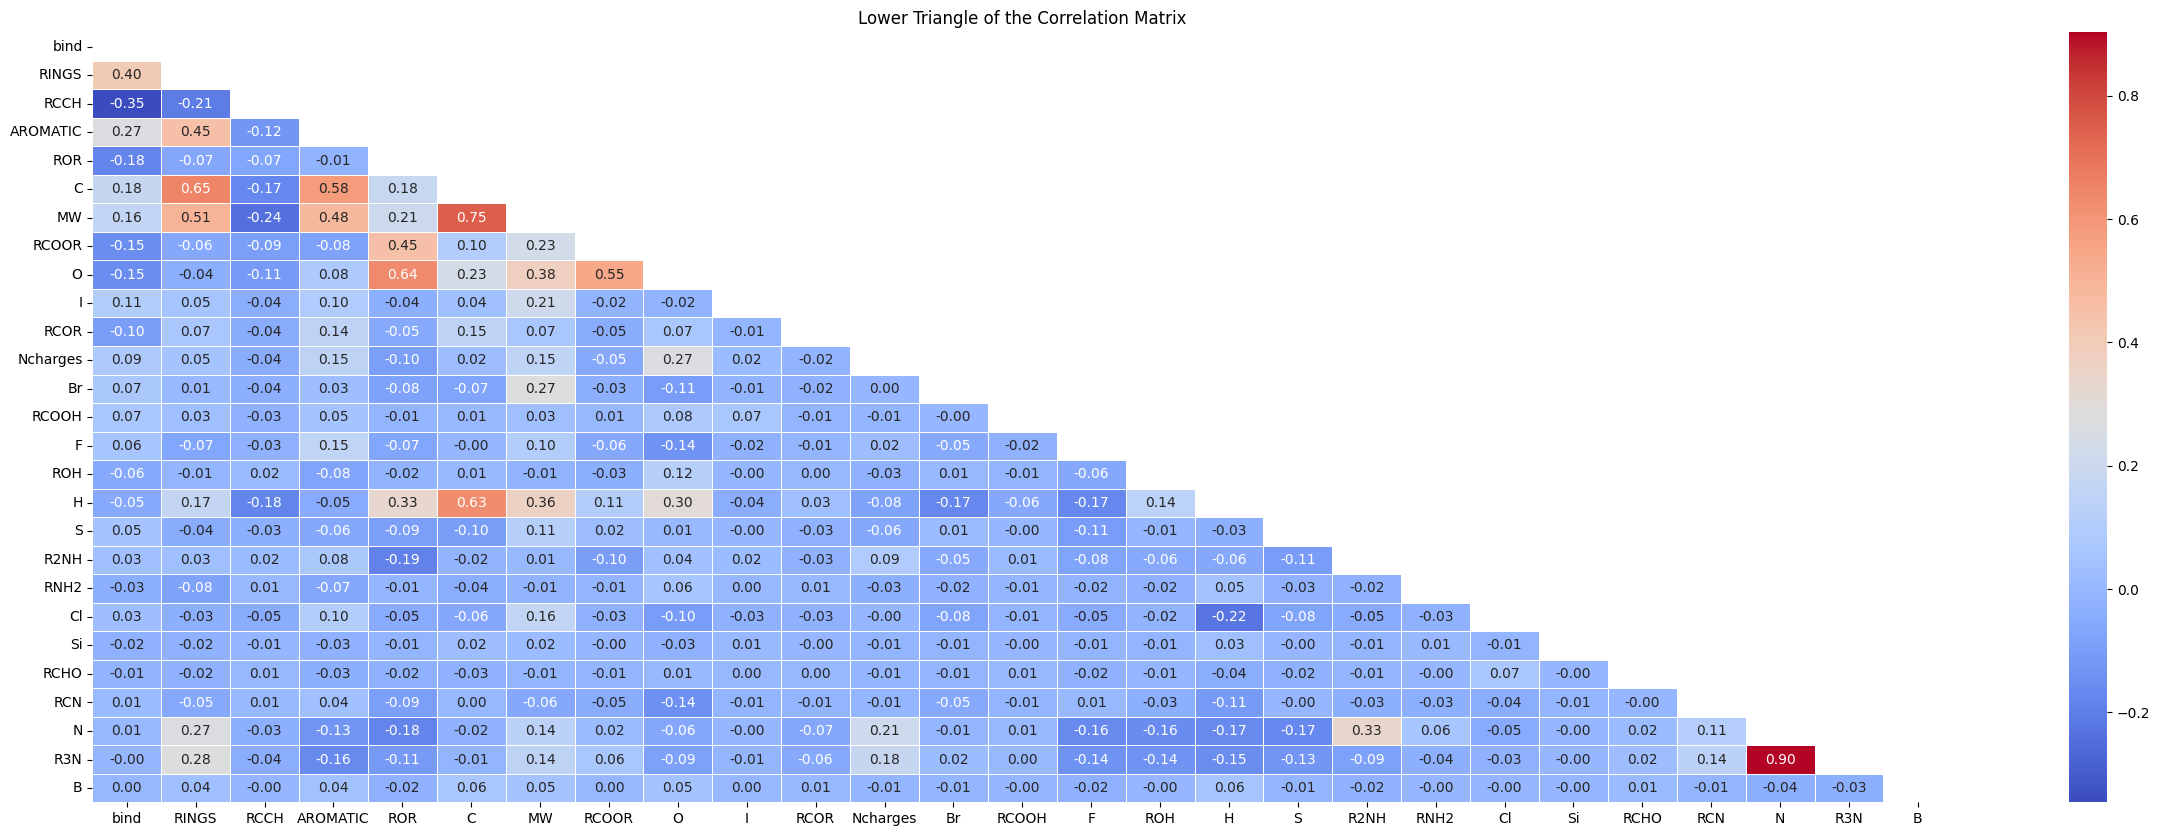

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a mask to display only the lower triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the lower triangle of the correlation matrix using a heatmap
plt.figure(figsize=(30, 10))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Lower Triangle of the Correlation Matrix')
plt.show()

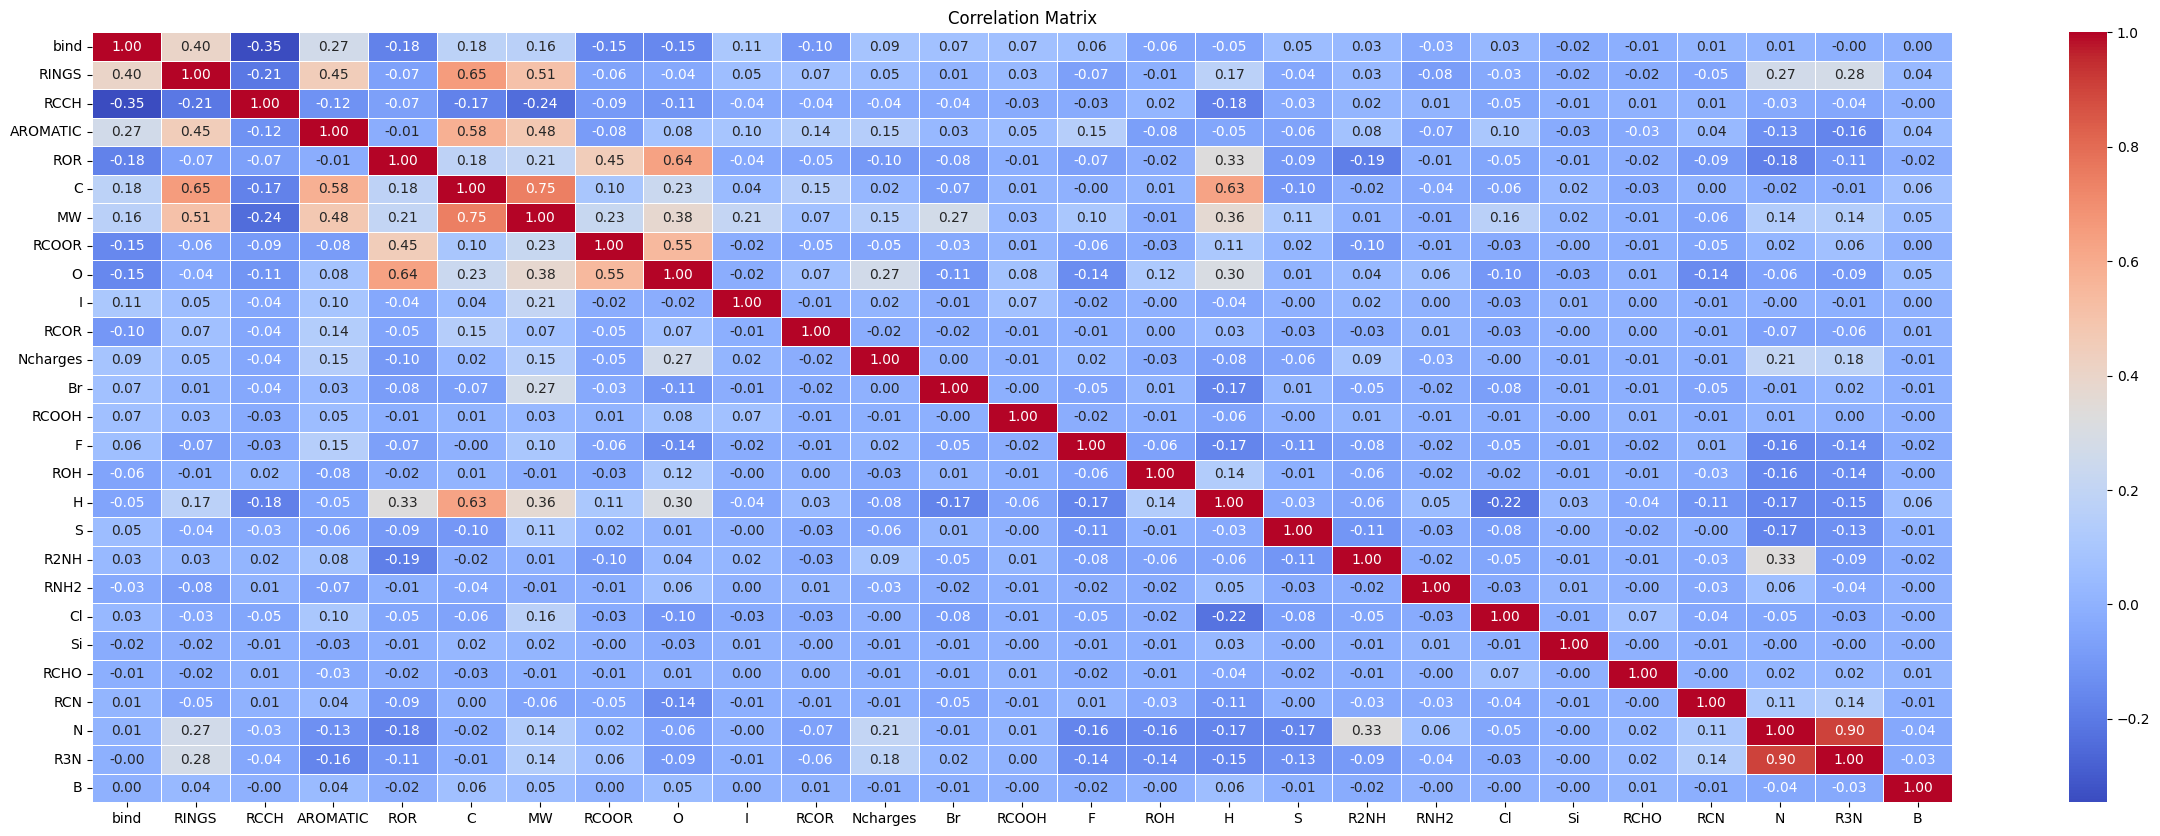

In [39]:
# Plot the correlation matrix using a heatmap

plt.figure(figsize=(30, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlations of atom and mol group', fontsize=14)
plt.title('Correlation Matrix')
plt.show()

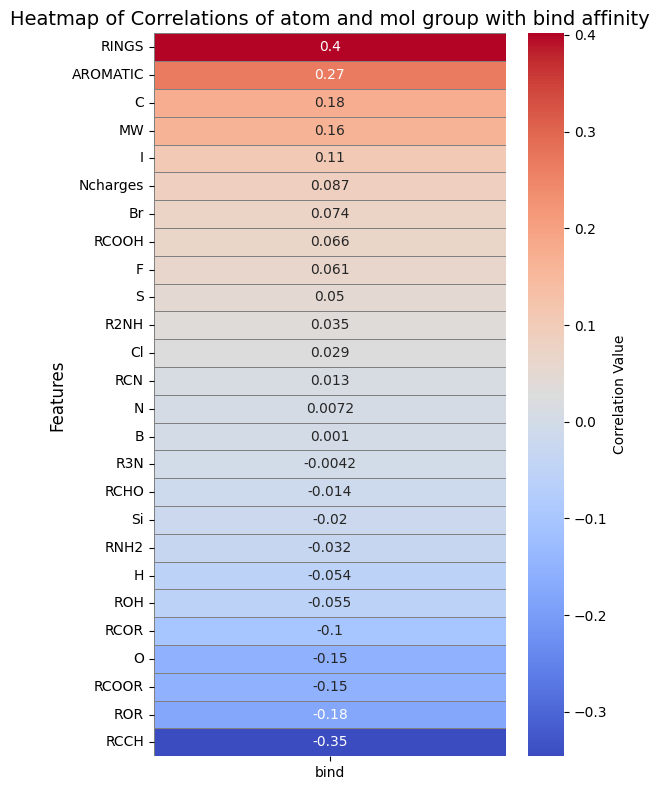

In [38]:
bind_correlation = correlation_matrix['bind'].sort_values(ascending=False)
# Convert the Series to a DataFrame for plotting
bind_correlation_df = bind_correlation.to_frame(name='bind')[1:]

# Plotting the heatmap of the single column
plt.figure(figsize=(6, 8))
sns.heatmap(bind_correlation_df, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation Value'}, linewidths=0.5, linecolor='gray')
plt.title('Heatmap of Correlations of atom and mol group with bind affinity', fontsize=14)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
# Sample df_zeros to have the same number of rows as df_ones
sampled_df_zeros = df_zeros.sample(n=10000, random_state=42)
sampled_df_ones = df_ones.sample(n=10000, random_state=42)

# Define the atom columns (update if more atom types are present)
atom_columns = ['C', 'H', 'N', 'O', 'Cl', 'S', 'F', 'Br', 'I', 'B', 'Si']

# Melting dataframes to plot a grouped boxplot
df_zeros_melted = sampled_df_zeros[atom_columns].melt(var_name='Atom', value_name='Frequency')
df_zeros_melted['Dataset'] = 'Zeros'

df_ones_melted = sampled_df_ones[atom_columns].melt(var_name='Atom', value_name='Frequency')
df_ones_melted['Dataset'] = 'Ones'

# Combine the melted dataframes
combined_df = pd.concat([df_zeros_melted, df_ones_melted], ignore_index=True)



In [16]:
combined_df.tail()

,Atom,Frequency,Dataset
219995,Si,0,Ones
219996,Si,0,Ones
219997,Si,0,Ones
219998,Si,0,Ones
219999,Si,0,Ones


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

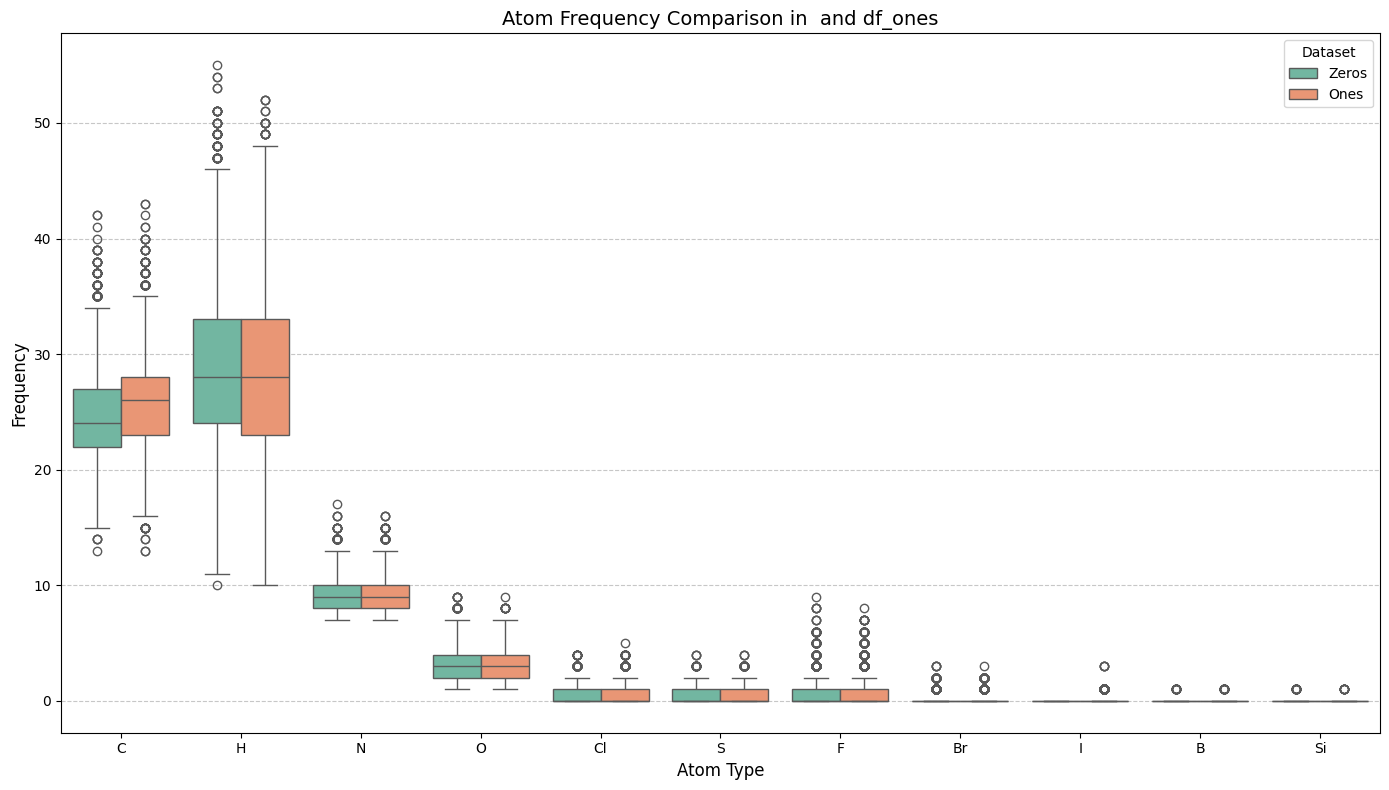

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns

# Create a grouped box plot for comparison of atom frequencies
plt.figure(figsize=(14, 8))
sns.boxplot(x='Atom', y='Frequency', hue='Dataset', data=combined_df, palette='Set2')
plt.title('Atom Frequency Comparison in  and df_ones', fontsize=14)
plt.xlabel('Atom Type', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Dataset', loc='upper right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [19]:
# Sample df_zeros to have the same number of rows as df_ones

sampled_df_zeros = df_zeros.sample(n=10000, random_state=42)
sampled_df_ones = df_ones.sample(n=10000, random_state=42)

# Define the atom columns (update if more atom types are present)
group_columns = ['RNH2', 'R2NH', 'R3N', 'ROPO3', 'ROH', 'RCHO', 'RCOR', 'RCOOH', 'RCOOR', 'ROR', 'RCCH', 'RCN', 'RINGS', 'AROMATIC']

# Melting dataframes to plot a grouped boxplot
df_zeros_melted = sampled_df_zeros[group_columns].melt(var_name='Group', value_name='Frequency')
df_zeros_melted['Dataset'] = 'Zeros'

df_ones_melted = sampled_df_ones[group_columns].melt(var_name='Group', value_name='Frequency')
df_ones_melted['Dataset'] = 'Ones'

# Combine the melted dataframes
combined_df = pd.concat([df_zeros_melted, df_ones_melted], ignore_index=True)


In [20]:
combined_df

,Group,Frequency,Dataset
0,RNH2,1,Zeros
1,RNH2,0,Zeros
2,RNH2,0,Zeros
3,RNH2,0,Zeros
4,RNH2,0,Zeros
...,...,...,...
279995,AROMATIC,2,Ones
279996,AROMATIC,0,Ones
279997,AROMATIC,2,Ones
279998,AROMATIC,3,Ones


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

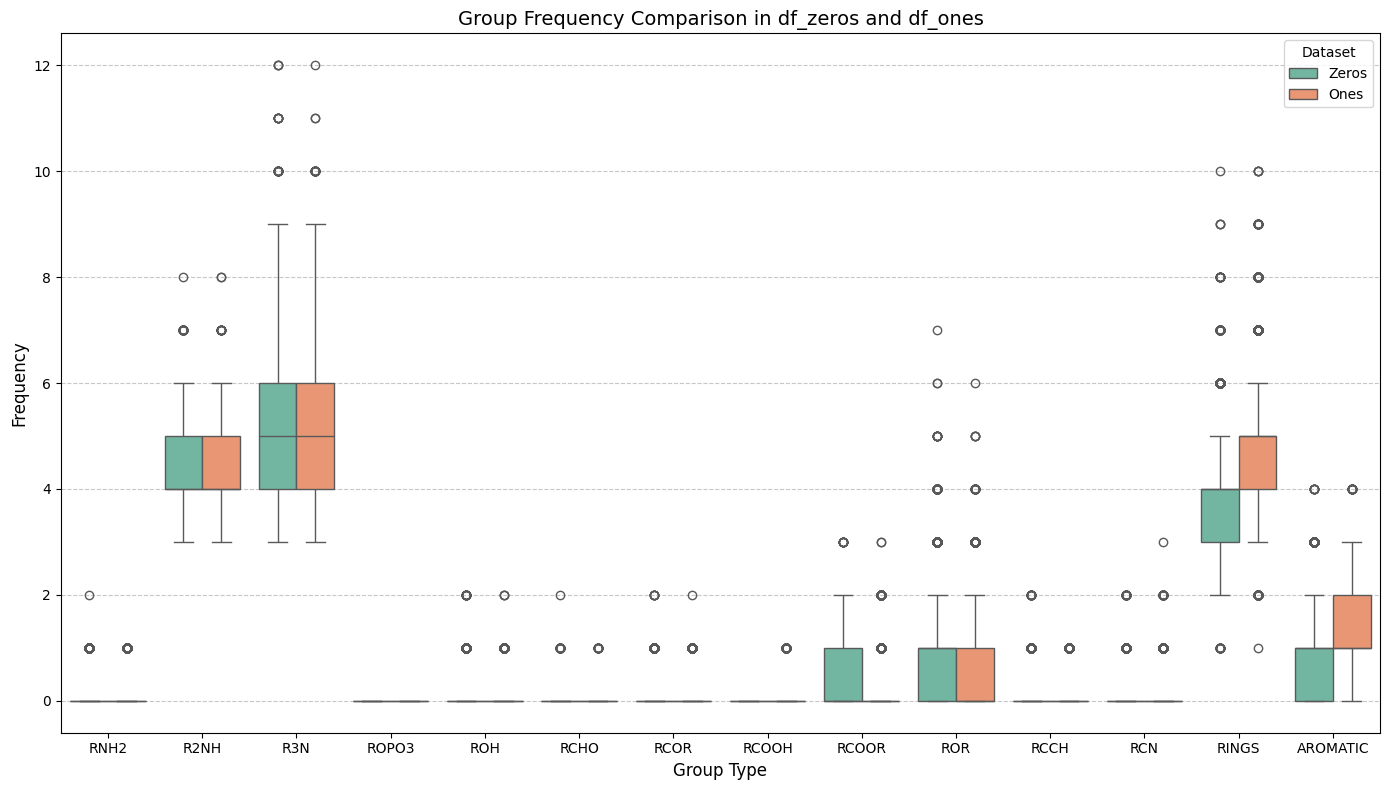

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns

# Create a grouped box plot for comparison of atom frequencies
plt.figure(figsize=(14, 8))
sns.boxplot(x='Group', y='Frequency', hue='Dataset', data=combined_df, palette='Set2')
plt.title('Group Frequency Comparison in df_zeros and df_ones', fontsize=14)
plt.xlabel('Group Type', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Dataset', loc='upper right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()